## User Guide:
To decompose a beam, call the decompose function below with your beat images loaded in. 

Note that the processes for approximating a beam parameter that this program automates (taking x and y slices of a beam through the center and using these to estimate diameter and wavefront curvature) only work reliably for roughly gaussian beams.

You should use the crop function defined below to eliminate as much noise in the beam image as possible and roughly center the beam on the camera so as to prevent rolling the beam over an edge when the program centers it using the pixels' center of mass

In [1]:
import hpc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pykat as pk
import pykat.optics.gaussian_beams as gb
import pykat.math as pkmath
from PIL import Image
from statistics import mean
import scipy as sp
import math
from scipy import ndimage
from scipy.optimize import least_squares

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5


                                              ..-
    PyKat 1.2.2           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



C:\Users\fritz\anaconda3\lib\site-packages\pykat\__init__.py:65: UserWarning: Could not find the finesse executable 'kat'or you do not have the permissions to run it.
  warn(msg)


## Mode Decomposition Related Functions

In [76]:
#requires at least four images of beat note and image of probe beam
#give decompose function below loaded in numpy arrays for ^ 
#you should crop the image as much as possible to focus in on beam to be decomposed

'''
To do: Provide support for other PSAs, simply define the function for it below and add the calls

'''

def beam_shift_center(image):
    #centers a beam's center of mass at the center of the frame. Note: accomplishes this by rolling array values over the edges of the frame, so for best results, center beam in frame as much as possible.
    cm = ndimage.measurements.center_of_mass(image)
    ishift = int(round(len(image[0])/2-cm[1]))
    jshift = int(round(len(image)/2-cm[0]))
    beampic = image
    beampic = np.roll(beampic,ishift,axis = 1)
    beampic = np.roll(beampic,jshift,axis = 0)

    return(beampic)

def fourpoint(piclist):
    arr1 = np.ravel(np.array(piclist[0],dtype='int'))
    arr2 = np.ravel(np.array(piclist[1],dtype='int')) #converts to numpy arrays for faster operation
    arr3 = np.ravel(np.array(piclist[2],dtype='int'))
    arr4 = np.ravel(np.array(piclist[3],dtype='int'))
    phase = np.empty(len(piclist[0])*len(piclist[0][0]))
    mask = np.ones(len(piclist[0])*len(piclist[0][0]),dtype=bool)
    cuts = np.where(arr1 < 15)
    mask[cuts] = False
    p1 = arr1[mask]
    p2 = arr2[mask]
    p3 = arr3[mask]
    p4 = arr4[mask]
    num = p4 - p2
    den = p1 - p3
    pha = np.arctan2(num,den)
    phase[~mask] = 0
    phase[mask] = pha
    phase = np.reshape(phase,(len(piclist[0]),len(piclist[0][0])))
    return(phase)

def subtract_center_phase(phasemap):
    avcenterphase = []
    for i in range(41):
        for j in range(41):
            avcenterphase.append(phasemap[int(len(phasemap)/2)-40+i][int(len(phasemap[0])/2)-40+j])
    average = sum(avcenterphase)/len(avcenterphase)
    centerphase = np.full((len(phasemap),len(phasemap[0])),average)
    return(phasemap-centerphase)

def curvaturebounds(diffphase):
    #Accepts wavefront image of beam with central phase subtracted out, returns indices that represent bounds of beam curvature through x,y slices through the center of wavefront
    #Only works with roughly gaussian beams' phase and intensity profiles. Otherwise you will have to deal with phase and intensity shifts across the intensity image and wavefront
    lxindex, rxindex, lyindex, ryindex = 0,0,0,0
    midldist = int(len(diffphase[0])/2)
    midrdist = -1*midldist
    for i in range(len(diffphase[0])-1):
        if diffphase[int(len(diffphase)/2)][i+1] - diffphase[int(len(diffphase)/2)][i] <= -1*math.pi and int(len(diffphase[0])/2) - (i+1) < midldist and int(len(diffphase[0])/2) - (i+1) > 0:
            lxindex = i+1
            midldist = int(len(diffphase[0])/2)-(i+1)
        if diffphase[int(len(diffphase)/2)][i+1] - diffphase[int(len(diffphase)/2)][i] >= 1*math.pi and int(len(diffphase[0])/2) - (i) > midrdist and int(len(diffphase[0])/2) - (i) < 0:
            rxindex = i+1
            midrdist = int(len(diffphase[0])/2) - (i)
    mid = int(len(diffphase)/2)
    midldist = int(len(diffphase)/2)
    midrdist = -1*midldist
    for j in range(len(diffphase)-1):
        if diffphase[j+1][mid] - diffphase[j][mid] <= -1*math.pi and int(len(diffphase)/2) - (j+1) < midldist and int(len(diffphase)/2) - (j+1) > 0:
            lyindex = j+1
            midldist = int(len(diffphase)/2) - (j+1)
        if diffphase[j+1][mid] - diffphase[j][mid] >= 1*math.pi and int(len(diffphase)/2) - (j) > midrdist and int(len(diffphase)/2) - (j) < 0:
            ryindex = j+1
            midrdist = int(len(diffphase)/2) - (j)
    return([lxindex, rxindex, lyindex, ryindex])

def phaseparabola(x,Rc,j,h):
    #approximates wavefront curvature by fitting a parabola
    k = 2*np.pi/1064e-9
    phase = (k/(2*Rc))*((x-h)**2)+j
    return phase

def gaussianequation(x,P,w,a):
    #returns power, waist size, horz offset
    intensity = (2*P)/(math.pi*(w**2))*np.exp(-2*(x+a)**2/(w**2))
    return intensity

def radcurvapprox(diffphase):
    #approximates x and y wavefront curvatures and takes the mean to approximate radius of curvature of wavefront
    indexlist = curvaturebounds(diffphase)
    xrange = np.linspace(indexlist[0]*6.9e-6,indexlist[1]*6.9e-6,indexlist[1]-indexlist[0])
    yrange = np.linspace(indexlist[2]*6.9e-6,indexlist[3]*6.9e-6,indexlist[3]-indexlist[2])
    xpopt, pcov = sp.optimize.curve_fit(phaseparabola,xrange,diffphase[int(len(diffphase)/2)][indexlist[0]:indexlist[1]],[-1,3,0])
    ypopt, pcov = sp.optimize.curve_fit(phaseparabola,yrange,diffphase[indexlist[2]:indexlist[3],int(len(diffphase[0])/2)],[-3,0,0])
    meanRC = abs((xpopt[0]+ypopt[0])/2)
    return(meanRC)

def waistsizeapprox(probebeam):
    #measures approx. x and y waist sizes of intensity image of probe beam, returns average to approx beam parameter
    normprob = probebeam/(np.sum(np.sum(probebeam))*((6.9e-6)**2))
    probdata = normprob[int(len(normprob)/2)]
    yprobdata = normprob[:,int(len(normprob[0])/2)]
    x = np.linspace(-6.9e-6*(int(len(probebeam[0])/2)),6.9e-6*(int(len(probebeam[0])/2)),len(probebeam[0])) #dimensions of probe beam image
    y = np.linspace(-6.9e-6*(int(len(probebeam)/2)),6.9e-6*(int(len(probebeam)/2)),len(probebeam))
    x1popt, pcov = sp.optimize.curve_fit(gaussianequation,x,probdata)
    y1popt, pcov = sp.optimize.curve_fit(gaussianequation,y,yprobdata)
    meanw = abs((x1popt[1]+y1popt[1])/2)
    return(meanw)

def HG_mode_content_1(w, rc, beam_data, X, Y, max_order, Print=True):
    #decomposes beam using optimal parameter with values calculated above
    import pykat.optics.gaussian_beams as gb
    q = gb.BeamParam(w=w,rc=rc)
    #print(q.Rc)
    sq_sum = 0
    c_nm = []
    modes = []
    cnm = []
    var_nm = mode_indices(max_order)
    for i in range(int((max_order+1)*(max_order+2)/2)):
        HG_mode = gb.HG_mode(q, n=var_nm[i][0], m=var_nm[i][1])
        HG_field = HG_mode.Unm(X,Y)
        k_nm = np.sum(np.multiply(np.conj(beam_data), HG_field))*np.diff(X)[0]*np.diff(Y)[0]
        sq_sum += np.abs(k_nm)**2
        cnm.append((var_nm[i],k_nm))
        modes.append([var_nm[i][0],var_nm[i][1]])
        if Print==True:
            print('%i%i: Mag: %.8E     Ang: %.2F'  % (var_nm[i][0], var_nm[i][1], np.abs(k_nm), np.angle(k_nm, deg=True)))
            c_nm.append([var_nm[i], np.abs(k_nm), np.angle(k_nm, deg=True)])
        else:
            c_nm.append([var_nm[i], np.abs(k_nm), np.angle(k_nm, deg=True)])
    print('Squared sum:', sq_sum)
    return c_nm,cnm,modes,q

def create_field(nm,q,x,y):
    #creating a field map as a reference
    import pykat as pk
    TEM = pk.optics.gaussian_beams.HG_mode(q,n=nm[0],m=nm[1])
    field = TEM.Unm(y,x)
    return field

def recompose(Cnm,mode,q,x,y): #how to structure variables
    # Cnm complex list of weights
    # mode list of indixes (n,m)
    # q beam parameter
    # x,y position vectors defining grid size 
    
    import numpy as np
    
    recomposed_field, trash = np.meshgrid(x,y)
    recomposed_field.astype(complex)
    
    for i in range(len(mode)):
        Unm = create_field(mode[i],q,x,y)
        recomposed_field = recomposed_field + Unm * Cnm[i]
        
    return recomposed_field

def mode_indices(max_order):
    #returns ordered paired of mode indices (m,n) up to max order
    mode_list = []
    for i in range(max_order+1):
        for j in range(i+1):
            mode_list.append((j,i-j))
    return mode_list

def CnmTo2d(Cnm,max_order): #turns cnm into 2d np array compatible with lg extract
    a = np.zeros(shape=(max_order+1,max_order+1), dtype = np.complex)
    for i in range(len(Cnm)):
        a[Cnm[i][0][0]][Cnm[i][0][1]] = Cnm[i][1]
    return a

def extract_LG_HG(Cnm,max_order=None, show = False):
    #accepts a 2d numpy array of HG coefficients where [r,c] of array corresponds to mode indices, returns 2d numpy array of LG mode coefficients up to a specified max order
    #extracting LG modes up to p,l requires HG modes up to n,m such that n+0 and 0+m = 2p + l
    if max_order==None:
        max_order==3
    if Cnm.size < (((max_order+1)*(max_order+2))/2):
        print("Your list of HG mode indices and coefficients does not contain sufficient amplitude coefficients to extract as many LG coefficients as specified")
        return
    LG_indices = mode_indices(max_order)
    LG_coeffs = [] # when p is non zero bounds on l changes.
    sig_sums = 0 #hg to helical 
    for p in range(max_order+1):
        for l in range(-(max_order),max_order+1):
            try:
                a, b, c = gb.LG2HG(p,l)
                for i in range(len(a)):
                    n = b[i]
                    m = c[i]
                    sig_sums += (Cnm[int(n)][int(m)])*a[i]
                LG_coeffs += [((p,l),sig_sums)]
                sig_sums = 0
            except ValueError:
                continue
    if show:
        print(LG_coeffs)
    return LG_coeffs

def beamcrop(image,uleft,bleft,uright,bright):
    #crops a beam image to specified square 
    return(beam_shift_center(image[uleft:bleft,uright:bright]))


In [77]:
def decompose(probebeam,beat1,beat2,beat3,beat4,max_order):
    piclist = [beam_shift_center(beat1),beam_shift_center(beat2),beam_shift_center(beat3),beam_shift_center(beat4)]
    diffphase = subtract_center_phase(fourpoint(piclist))
    rc = radcurvapprox(diffphase)
    w = waistsizeapprox(beam_shift_center(probebeam))
    y = np.linspace(-6.9e-6*(int(len(probebeam[0])/2)),6.9e-6*(int(len(probebeam[0])/2)),len(probebeam[0])) #dimensions of probe beam image
    x = np.linspace(-6.9e-6*(int(len(probebeam)/2)),6.9e-6*(int(len(probebeam)/2)),len(probebeam))
    normprob = probebeam/(np.sum(np.sum(probebeam))*((6.9e-6)**2))
    beamphi = np.sqrt(normprob)*np.exp(1j*diffphase) #includes phase info in decomposition
    c_nm,cnm,modes,q = HG_mode_content_1(w,rc,beamphi,x,y,max_order)
    return([c_nm,cnm,modes,q,x,y,max_order])

## Example of Decomposition, Recomposition, and LG coeff Extraction

Decomposition Results
00: Mag: 9.61450912E-01     Ang: 32.46
01: Mag: 1.63668248E-02     Ang: 11.44
10: Mag: 3.47902885E-02     Ang: -130.88
02: Mag: 6.28137042E-02     Ang: -115.42
11: Mag: 1.09739409E-02     Ang: 53.21
20: Mag: 1.08150262E-01     Ang: -171.91
03: Mag: 3.92587014E-03     Ang: -124.92
12: Mag: 3.62165656E-03     Ang: -166.15
21: Mag: 2.25098567E-02     Ang: 127.51
30: Mag: 2.70059303E-02     Ang: 118.26
04: Mag: 3.51937881E-02     Ang: -10.00
13: Mag: 1.19909998E-02     Ang: -82.83
22: Mag: 3.22337283E-02     Ang: -104.72
31: Mag: 1.45392282E-02     Ang: -101.34
40: Mag: 7.04045792E-02     Ang: 5.79
05: Mag: 2.06611424E-03     Ang: -15.13
14: Mag: 1.80987965E-03     Ang: 83.64
23: Mag: 2.47337125E-03     Ang: 70.89
32: Mag: 6.86822155E-03     Ang: -46.95
41: Mag: 7.91511476E-03     Ang: -14.48
50: Mag: 2.04242094E-02     Ang: -0.02
06: Mag: 1.73120985E-02     Ang: 133.94
15: Mag: 1.02573124E-02     Ang: 157.03
24: Mag: 3.41315917E-02     Ang: 133.85
33: Mag: 4.93373434

[((0, -3), (0.009705726950512373+0.016540175930525196j)),
 ((0, -2), (-0.03384266317224+0.016110856944590742j)),
 ((0, -1), (-0.013804663171251539-0.029944108076979923j)),
 ((0, 0), (0.8112306779544897+0.5160355053183114j)),
 ((0, 1), (-0.018394221484120527-0.007257507131283206j)),
 ((0, 2), (-0.04627202105738385+0.025404178168860612j)),
 ((0, 3), (-0.014439367510799547+0.0013423396544531485j)),
 ((1, -3), (-0.006542579770023856+0.003180643864880508j)),
 ((1, -2), (-0.0046170126896007795-0.007290510384056939j)),
 ((1, -1), (0.004730658224332187-0.020482546507091706j)),
 ((1, 0), (0.09477599535517481+0.05087849242628518j)),
 ((1, 1), (0.013413968179231035-0.008038571043218772j)),
 ((1, 2), (-0.030769611270357544-0.005927601513695558j)),
 ((1, 3), (-0.007047365429116566-0.0037758251475040827j)),
 ((2, -3), (0.0016047891341596301-0.003782049040456301j)),
 ((2, -2), (0.00132537677410803+0.006950160321876709j)),
 ((2, -1), (0.013155070946255416-0.004646659727288999j)),
 ((2, 0), (0.06002167

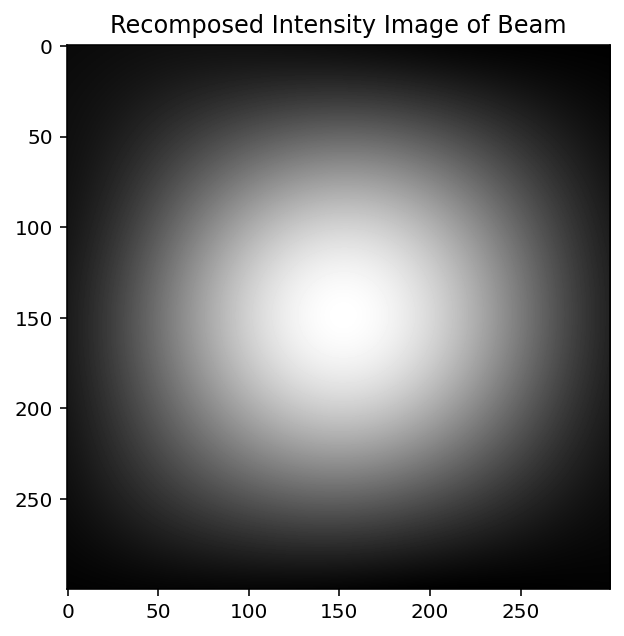

In [82]:
probebeam = beam_shift_center(np.load("probe_beam_0608_0.npy"))
newprobe = beam_shift_center(probebeam[100:400,200:500])

beat1 = beamcrop(beam_shift_center(np.load("0608_0.npy")),100,400,200,500)
beat2 = beamcrop(beam_shift_center(np.load("0608_1.npy")),100,400,200,500)
beat3 = beamcrop(beam_shift_center(np.load("0608_2.npy")),100,400,200,500)
beat4 = beamcrop(beam_shift_center(np.load("0608_3.npy")),100,400,200,500)

print("Decomposition Results")
decomplist = decompose(newprobe,beat1,beat2,beat3,beat4,10)

#raw list of amplitude coeffs:
ampcoeffs = [k[1] for k in decomplist[1]]

#Recomposition Code
plt.imshow(np.abs(recompose(ampcoeffs,decomplist[2],decomplist[3],decomplist[4],decomplist[5])),cmap = 'gray')
plt.title("Recomposed Intensity Image of Beam")

#LG Extraction Code 
'''
!!!Note that for some reason the lg2hg conversion function doesn't like certain LG index combos like (4,-4)
In this code it skips them, but because I'm not sure why they cause problems, I would keep LG extraction between (3,-3) and (3,3)
'''
print("LG Extraction Results")
extract_LG_HG(CnmTo2d(decomplist[1],decomplist[6]), max_order = 3)